# Petals to the Metal
> Getting Started with TPUs on Kaggle!

- toc: true
- badges: true
- author: Austin Chen
- categories: [plant,classification,tpu]


In [16]:
#hide
%%writefile conditional_cell_extension.py
def run_if(line, cell=None):
    '''Execute current line/cell if line evaluates to True.'''
    if not eval(line):
        return
    get_ipython().ex(cell)

def load_ipython_extension(shell):
    '''Registers the run_if magic when the extension loads.'''
    shell.register_magic_function(run_if, 'line_cell')

def unload_ipython_extension(shell):
    '''Unregisters the run_if magic when the extension unloads.'''
    del shell.magics_manager.magics['cell']['run_if']


Overwriting conditional_cell_extension.py


In [17]:
#hide
%reload_ext skip_kernel_extension

In [18]:
#collapse-hide
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
import os, gc, cv2, random, re
import warnings, math, sys, json, pprint, pdb

import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

warnings.simplefilter('ignore')
print(f"Using TensorFlow v{tf.__version__}")

Using TensorFlow v2.4.0


In [19]:
#hide_output
#@title Accelerator { run: "auto" }
DEVICE = 'TPU' #@param ["None", "'GPU'", "'TPU'"] {type:"raw", allow-input: true}

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTOTUNE = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Could not connect to TPU
Using default strategy for CPU and single GPU
Num GPUs Available:  0
REPLICAS: 1


> Tip: Adding seed helps reproduce results. Setting debug parameter wil run the model on smaller number of epochs to validate the architecture.

In [21]:
#collapse-hide
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

GOOGLE = 'google.colab' in str(get_ipython())
KAGGLE = not Colab

In [15]:
#hide
#@title ML Lifecycle { run: "auto", display-mode: "form" }
SEED = 16
DEBUG = False #@param {type:"boolean"}
TRAIN = True #@param {type:"boolean"}
INFERENCE = True #@param {type:"boolean"}

seed_everything(SEED)


In [22]:
#hide
%%run_if {GOOGLE}
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [30]:
project_name = 'tpu-getting-started'
root_path  = '/content/gdrive/MyDrive/' if GOOGLE else '/'
input_path = f'{root_path}kaggle/input/{project_name}/'
working_path = f'{input_path}working/' if GOOGLE else '/kaggle/working/'
os.makedirs(working_path, exist_ok=True)
os.chdir(working_path)
os.listdir(input_path)

['working']

# TFRecord basics

In [ ]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/flowers'
SHARDS = 16
TARGET_SIZE = [192, 192]
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

### Read images and labels

In [ ]:
def decode_image_and_label(filename):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits)
    label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
    #label = tf.strings.split(filename, sep='/')
    label = label.values[-2]
    label = tf.cast((CLASSES==label), tf.int8)
    return image, label

In [ ]:
 filenames = tf.data.Dataset.list_files(GCS_PATTERN, seed=16)

In [ ]:
for x in filenames.take(10): print(x)

tf.Tensor(b'gs://flowers-public/tulips/251811158_75fa3034ff.jpg', shape=(), dtype=string)
tf.Tensor(b'gs://flowers-public/daisy/506348009_9ecff8b6ef.jpg', shape=(), dtype=string)
tf.Tensor(b'gs://flowers-public/daisy/2019064575_7656b9340f_m.jpg', shape=(), dtype=string)
tf.Tensor(b'gs://flowers-public/tulips/8713396140_5af8136136.jpg', shape=(), dtype=string)
tf.Tensor(b'gs://flowers-public/roses/218630974_5646dafc63_m.jpg', shape=(), dtype=string)
tf.Tensor(b'gs://flowers-public/roses/410421672_563550467c.jpg', shape=(), dtype=string)
tf.Tensor(b'gs://flowers-public/tulips/8614237582_74417799f4_m.jpg', shape=(), dtype=string)
tf.Tensor(b'gs://flowers-public/dandelion/8797114213_103535743c_m.jpg', shape=(), dtype=string)
tf.Tensor(b'gs://flowers-public/dandelion/11296320473_1d9261ddcb.jpg', shape=(), dtype=string)
tf.Tensor(b'gs://flowers-public/dandelion/14554897292_b3e30e52f2.jpg', shape=(), dtype=string)


In [ ]:
ds0 = filenames.map(decode_image_and_label, num_parallel_calls=AUTOTUNE)

In [31]:
def show_images(ds):
    _,axs = plt.subplots(3,3,figsize=(16,16))
    for ((x, y), ax) in zip(ds.take(9), axs.flatten()):
        ax.imshow(x.numpy().astype(np.uint8))
        ax.set_title(np.argmax(y))
        ax.axis('off')

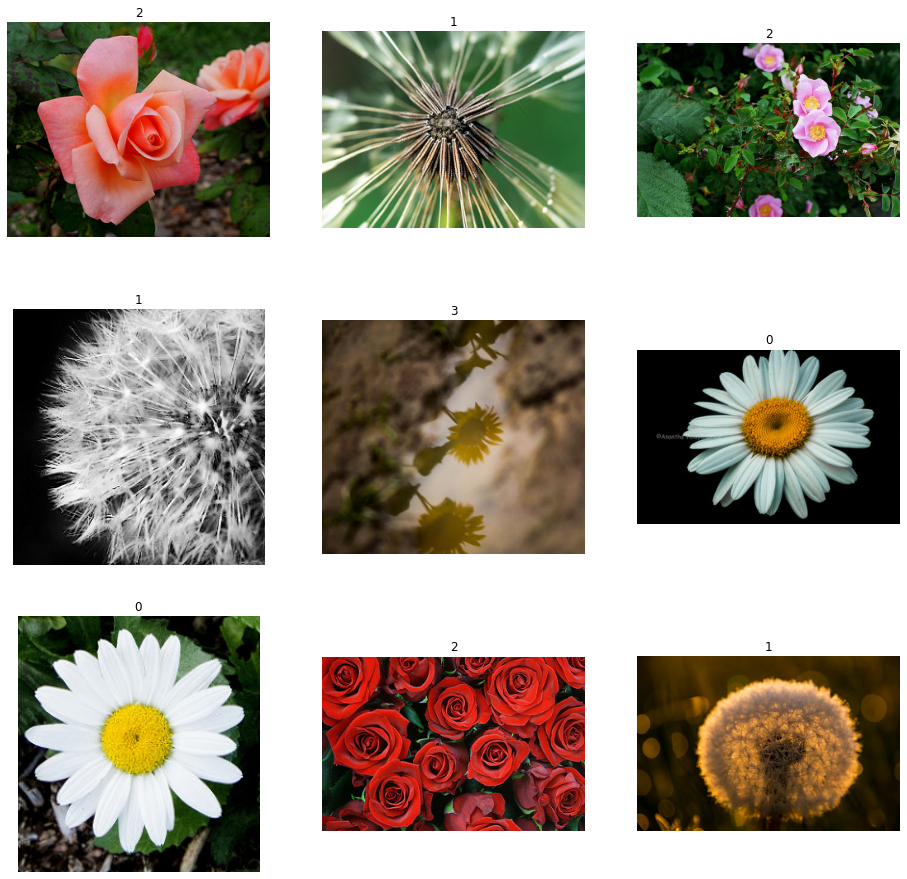

In [ ]:
 show_images(ds0)

### Resize and crop images to common size

No need to study the code in this cell. It's only image resizing.




In [ ]:
def resize_and_crop_image(image, label):
    # Resize and crop using "fill" algorithm:
    # always make sure the resulting image
    # is cut out from the source image so that
    # it fills the TARGET_SIZE entirely with no
    # black bars and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                   )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

In [ ]:
ds1 = ds0.map(resize_and_crop_image, num_parallel_calls=AUTOTUNE) 

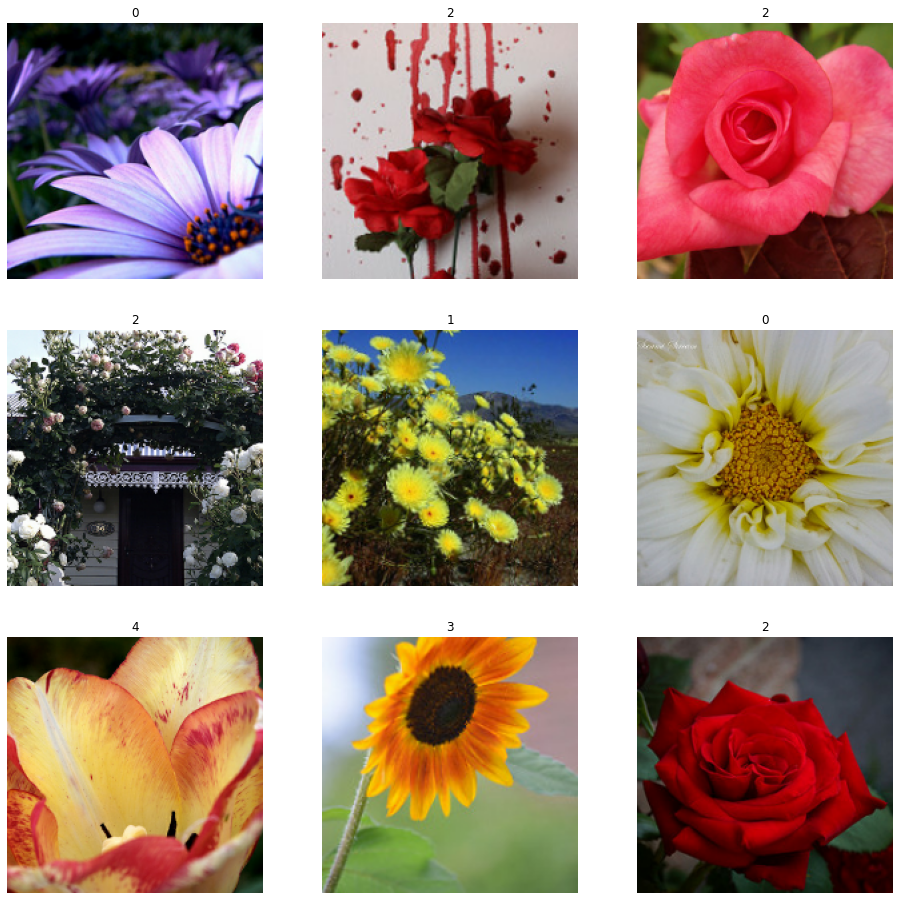

In [ ]:
show_images(ds1)

### Speed test: too slow

Google Cloud Storage is capable of great throughput but has a per-file access penalty. Run the cell below and see that throughput is around 8 images per second. That is too slow. Training on thousands of individual files will not work. We have to use the *TFRecord* format to group files together.

In [ ]:
%%time
for image,label in ds1.batch(8).take(10):
    print("Image batch shape {} {}".format(
        image.numpy().shape,
        [np.argmax(lbl) for lbl in label.numpy()]))

Image batch shape (8, 192, 192, 3) [0, 1, 0, 0, 1, 3, 2, 1]
Image batch shape (8, 192, 192, 3) [3, 4, 4, 0, 3, 4, 3, 0]
Image batch shape (8, 192, 192, 3) [0, 3, 0, 4, 2, 4, 2, 4]
Image batch shape (8, 192, 192, 3) [3, 4, 4, 0, 2, 3, 2, 3]
Image batch shape (8, 192, 192, 3) [1, 3, 4, 3, 0, 3, 1, 3]
Image batch shape (8, 192, 192, 3) [4, 4, 3, 0, 0, 4, 4, 1]
Image batch shape (8, 192, 192, 3) [1, 3, 1, 3, 1, 2, 4, 2]
Image batch shape (8, 192, 192, 3) [1, 4, 2, 4, 2, 2, 1, 0]
Image batch shape (8, 192, 192, 3) [0, 3, 2, 2, 3, 4, 0, 1]
Image batch shape (8, 192, 192, 3) [1, 2, 0, 1, 0, 3, 4, 1]
CPU times: user 65.8 ms, sys: 42.5 ms, total: 108 ms
Wall time: 4.39 s


### Recompress the images

The bandwidth savings outweight the decoding CPU cost

In [ ]:
def recompress_image(image, label):
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label, height, width

In [ ]:
IMAGE_SIZE = len(tf.io.gfile.glob(GCS_PATTERN))
SHARD_SIZE = math.ceil(1.0 * IMAGE_SIZE / SHARDS)

In [ ]:
ds2 = ds1.map(recompress_image, num_parallel_calls=AUTOTUNE)
ds2 = ds2.batch(SHARD_SIZE) # sharding: there will be one "batch" of images per file

### Why TFRecords?

TPUs have eight cores which act as eight independent workers. We can get data to each core more efficiently by splitting the dataset into multiple files or *shards*. This way, each core can grab an independent part of the data as it needs.
The most convenient kind of file to use for sharding in TensorFlow is a TFRecord. A TFRecord is a binary file that contains sequences of byte-strings. Data needs to be serialized (encoded as a byte-string) before being written into a TFRecord.
The most convenient way of serializing data in TensorFlow is to wrap the data with `tf.Example`. This is a record format based on Google's protobufs but designed for TensorFlow. It's more or less like a dict with some type annotations

In [ ]:
x = tf.constant([[1,2], [3, 4]], dtype=tf.uint8)
print(x)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=uint8)


In [ ]:
x_in_bytes = tf.io.serialize_tensor(x)
print(x_in_bytes)

tf.Tensor(b'\x08\x04\x12\x08\x12\x02\x08\x02\x12\x02\x08\x02"\x04\x01\x02\x03\x04', shape=(), dtype=string)


In [ ]:
print(tf.io.parse_tensor(x_in_bytes, out_type=tf.uint8))

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=uint8)


A TFRecord is a sequence of bytes, so we have to turn our data into byte-strings before it can go into a TFRecord. We can use tf.io.serialize_tensor to turn a tensor into a byte-string and tf.io.parse_tensor to turn it back. It's important to keep track of your tensor's datatype (in this case tf.uint8) since you have to specify it when parsing the string back to a tensor again

### Write dataset to TFRecord files

> Note: Will uncomment the cells in this section when I find a `gs://` domain to write to.




In [ ]:
#def _bytestring_feature(list_of_bytestrings):
#    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))
#
#def _int_feature(list_of_ints): # int64
#    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))
#
#def _float_feature(list_of_floats): # float32
#    return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
#
#def to_tfrecord(tfrec_filewriter, img_bytes, label, height, width):
#    id = np.argmax(np.array(CLASSES)==label)
#    one_hot = np.eye(len(CLASSES))[id]
#    feature = {
#      "image": _bytestring_feature([img_bytes]), # one image in the list
#      "id":    _int_feature([id]),               # one class in the list
#      "label": _bytestring_feature([label]),     # fixed length (1) list of strings, the text label
#      "size" : _int_feature([height, width]),    # fixed length (2) list of ints
#      "one_hot": _float_feature(one_hot.tolist())# variable length  list of floats, n=len(CLASSES)
#    }
#    return tf.train.Example(features=tf.train.Features(feature=feature))

In [ ]:
#print("Writing TFRecords")
#for shard_id, (image, label, height, width) in ds2.enumerate():
#    shard_size = image.numpy().shape[0]
#    filename = GCS_OUTPUT + "{:02d}-{}tfrec".format(shard_id, shard_size)
#
#    with tf.io.TFRecordWriter(filename) as outfile:
#        for i in range(shard_size):
#            example = to_tfrecord(out_file,
#                                  image.numpy()[i],
#                                  label.numpy()[i],
#                                  height.numpy()[i],
#                                  width.numpy()[i])
#            out_file.write(example.SerializeToString())
#        print("Wrote file {} containing {} records".format(filename, shard_size))

### Read from TFRecord Dataset

In [ ]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64),  # two integers
        "one_hot_class": tf.io.VarLenFeature(tf.float32)        # a certain number of floats
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    
    label  = example['label']
    height = example['size'][0]
    width  = example['size'][1]
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    return image, class_num, label, height, width, one_hot_class

In [ ]:
option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

filenames = tf.io.gfile.glob(GCS_OUTPUT + "*tfrec")
ds3 = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
ds3 = (ds3.with_options(option_no_order)
         .map(read_tfrecord, num_parallel_calls=AUTOTUNE)
         .shuffle(30))

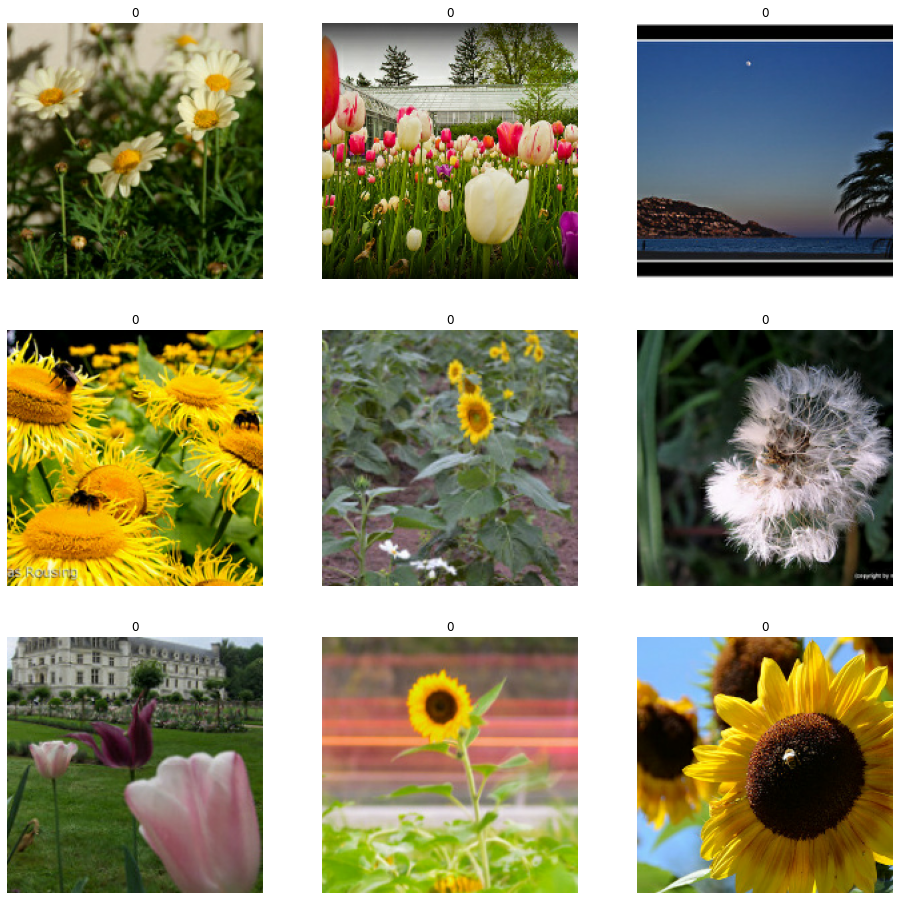

In [ ]:
ds3_to_show = ds3.map(lambda image, id, label, height, width, one_hot: (image, label))
show_images(ds3_to_show)

### Speed test: fast

Loading form TFRecords is almost 10x time faster than loading from JPEGs.

In [ ]:
%%time
for image, class_num, label, height, width, one_hot_class in ds3.batch(8).take(10):
    print("Image batch shape {} {}".format(
        image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (8, 192, 192, 3) ['tulips', 'dandelion', 'sunflowers', 'sunflowers', 'sunflowers', 'roses', 'dandelion', 'sunflowers']
Image batch shape (8, 192, 192, 3) ['sunflowers', 'tulips', 'tulips', 'dandelion', 'roses', 'dandelion', 'tulips', 'roses']
Image batch shape (8, 192, 192, 3) ['daisy', 'daisy', 'sunflowers', 'roses', 'tulips', 'daisy', 'roses', 'tulips']
Image batch shape (8, 192, 192, 3) ['roses', 'tulips', 'tulips', 'sunflowers', 'sunflowers', 'tulips', 'tulips', 'sunflowers']
Image batch shape (8, 192, 192, 3) ['sunflowers', 'dandelion', 'dandelion', 'daisy', 'tulips', 'dandelion', 'roses', 'dandelion']
Image batch shape (8, 192, 192, 3) ['roses', 'dandelion', 'tulips', 'daisy', 'dandelion', 'dandelion', 'dandelion', 'dandelion']
Image batch shape (8, 192, 192, 3) ['dandelion', 'sunflowers', 'daisy', 'sunflowers', 'sunflowers', 'sunflowers', 'dandelion', 'daisy']
Image batch shape (8, 192, 192, 3) ['roses', 'daisy', 'dandelion', 'sunflowers', 'sunflowers', 'daisy'

# Hyperparameters

In [32]:
#@title {run: "auto", display-mode: "form" }

BASE_MODEL = 'efficientnet_b3' #@param ["'efficientnet_b3'", "'efficientnet_b4'", "'efficientnet_b2'"] {type:"raw", allow-input: true}
HEIGHT = 300#@param {type:"number"}
WIDTH = 300#@param {type:"number"}
CHANNELS = 3#@param {type:"number"}
IMG_SIZE = (HEIGHT, WIDTH, CHANNELS)
EPOCHS =  50#@param {type:"number"}
BATCH_SIZE = 32 * strategy.num_replicas_in_sync #@param {type:"raw"}

print("Use {} with input size {}".format(BASE_MODEL, IMG_SIZE))
print("Train on batch size of {} for {} epochs".format(BATCH_SIZE, EPOCHS))

Use efficientnet_b3 with input size (300, 300, 3)
Train on batch size of 32 for 50 epochs


# Data

## Loading data

In [37]:
#@title {run: "auto", display-mode: "form"}
GCS_PATH = 'gs://kds-e93303da9a97ef8fd254ceb5e9ed104470f247527dd45aba9685bdf5' #@param {type: "string"}
GCS_PATH += '/tfrecords-jpeg-512x512' #@param {type: "string"}
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']
           
print(f"Sourcing images from {GCS_PATH}")


Sourcing images from gs://kds-e93303da9a97ef8fd254ceb5e9ed104470f247527dd45aba9685bdf5/tfrecords-jpeg-512x512


In [35]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=CHANNELS)
    image = (tf.cast(image, tf.float32) if GOOGLE
                else tf.cast(image, tf.float32) / 255.0)
    image = tf.image.random_crop(image, IMG_SIZE)
    return image
    
def collate_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

def process_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),    # shape [] means single element
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1))
            for filename in filenames]
    return np.sum(n)

In [38]:
train_filenames = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
valid_filenames = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
test_filenames  = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

In [39]:
 count_data_items(train_filenames)

0.0

## Data augmentation

In [ ]:
#collapse-show
def data_augment(image, label):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel = tf.random.uniform([], 0, 1.0, dtype=tf.float32)    
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shift = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    
    # Flips
    if p_spatial >= .2:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
    
    if p_rotation >= .3: # Rotation
        image = transform_rotation(image, height=HEIGHT, rotation=45.)
    if p_shift >= .3: # Shift
        image = transform_shift(image, height=HEIGHT, h_shift=15., w_shift=15.)
    if p_shear >= .3: # Shear
        image = transform_shear(image, height=HEIGHT, shear=20.)
        
    # Crops
    if p_crop > .4:
        crop_size = tf.random.uniform([], int(HEIGHT*.7), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
    elif p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.8)
        else:
            image = tf.image.central_crop(image, central_fraction=.9)
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])
        
    # Pixel-level transforms
    if p_pixel >= .2:
        if p_pixel >= .8:
            image = tf.image.random_saturation(image, lower=0, upper=2)
        elif p_pixel >= .6:
            image = tf.image.random_contrast(image, lower=.8, upper=2)
        elif p_pixel >= .4:
            image = tf.image.random_brightness(image, max_delta=.2)
        else:
            image = tf.image.adjust_gamma(image, gamma=.6)

    return image, label

In [ ]:
option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

In [ ]:
train_ds = tf.data.TFRecordDataset(train_filenames, num_parallel_reads=AUTOTUNE)
train_ds = (train_ds
            .map(collate_labeled_tfrecord, num_parallel_calls=AUTOTUNE)
            .map(data_augment, num_parallel_calls=AUTOTUNE)
            .repeat()
            .shuffle(2048)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))


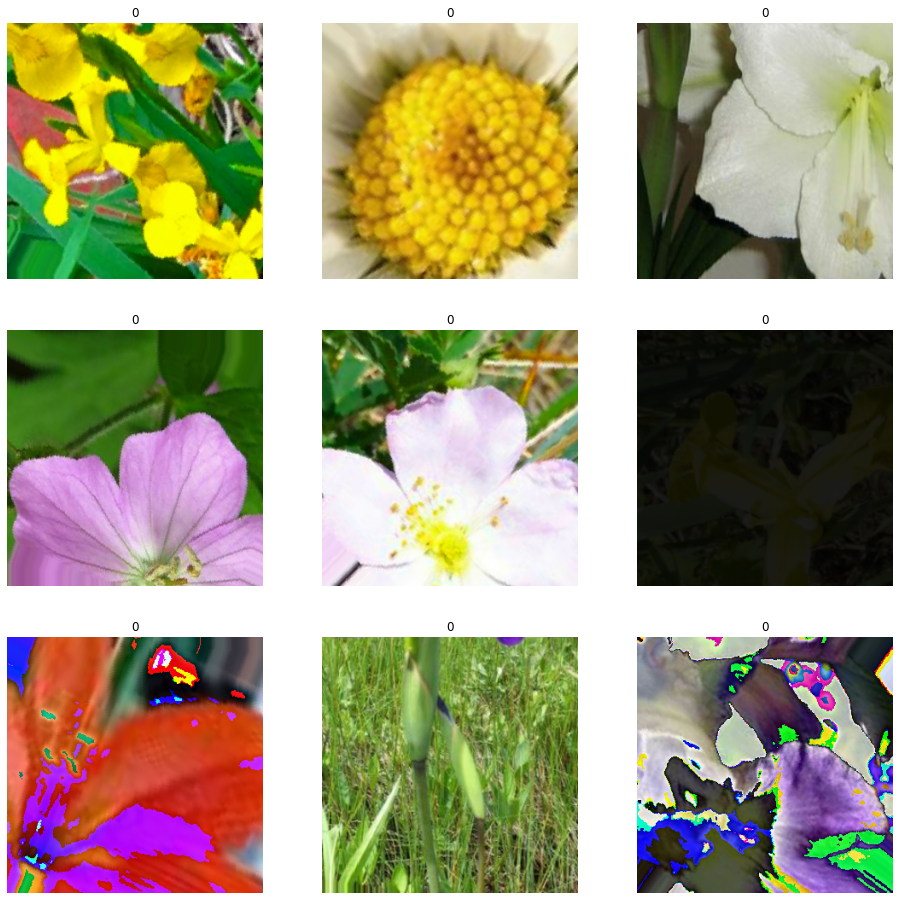

In [ ]:
show_images(train_ds.take(1).unbatch())

In [ ]:
valid_ds = tf.data.TFRecordDataset(valid_filenames, num_parallel_reads=AUTOTUNE)
valid_ds = (valid_ds
            .with_options(option_no_order)
            .map(collate_labeled_tfrecord, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
            .cache()
            .prefetch(AUTOTUNE))
            

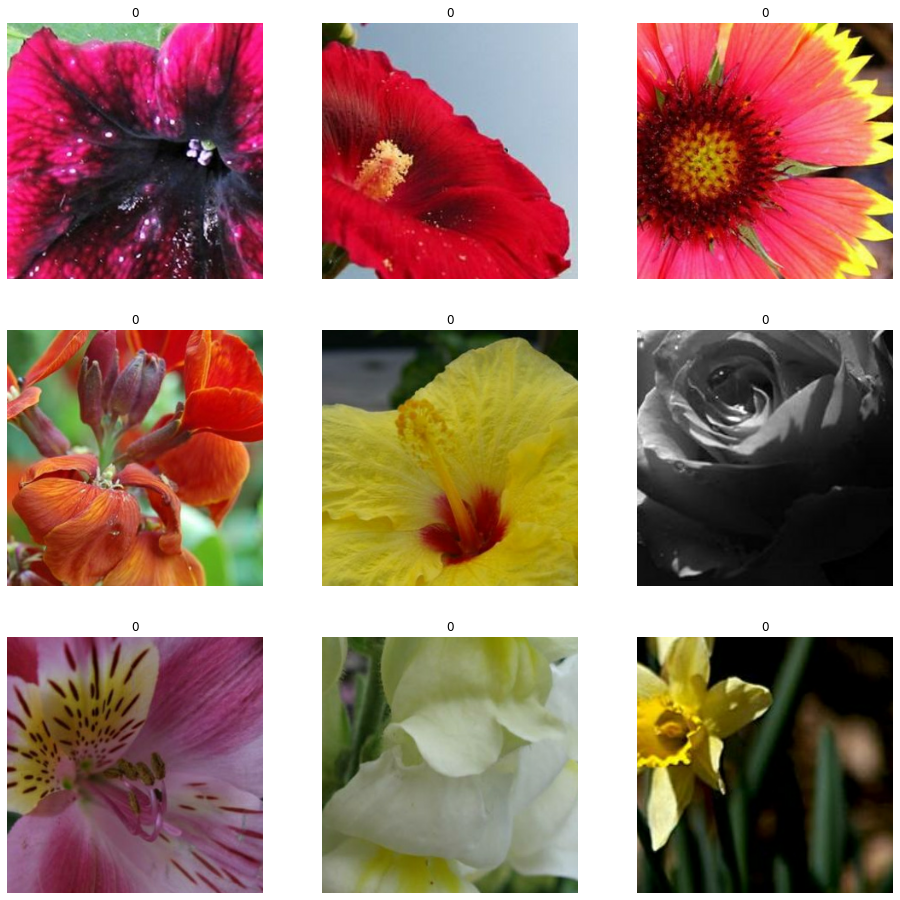

In [ ]:
show_images(valid_ds.take(1).unbatch())

In [ ]:
test_ds = tf.data.TFRecordDataset(test_filenames, num_parallel_reads=AUTOTUNE)
test_ds = (test_ds
            .with_options(option_no_order)
            .map(process_unlabeled_tfrecord, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))


# Model

## Batch augmentation

Augmentation can be applied in two ways.
- Using the [Keras Preprocessing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/)
- Using the [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image)

> Important: The [Keras Preprocessing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/) are currently experimental so it seems it does not have supporting TPU OpKernel yet.

In [ ]:
#batch_augment = tf.keras.Sequential(
#    [
#     tf.keras.layers.experimental.preprocessing.RandomCrop(*IMG_SIZE),
#     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.25),
#     tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
#     tf.keras.layers.experimental.preprocessing.RandomContrast((0.2,0.2))
#    ]
#)

In [ ]:
#func = lambda x,y: (batch_augment(x), y)
#x = (train_ds
#     .take(1)
#     .map(func, num_parallel_calls=AUTOTUNE))

## Building a model

Now we're ready to create a neural network for classifying images! We'll use what's known as *transfer learning*. With transfer learning, you reuse the body part of a pretrained model and replace its' head or tail with custom layers depending on the problem that we are solving.

For this tutorial, we'll use `EfficientNetb3` which is pretrained on ImageNet. Later, I might want to experiment with other models. (Xception wouldn't be a bad choice.)

> Important: The distribution strategy we created earilier contains a context manager, `straategy.scope`. This context manager tells TensorFlow how to divide the work of training among the eight TPU cores. When using TensorFlow with a TPU, it's important to define your model in `strategy.sceop()` context.


In [ ]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import VGG16

In [ ]:
def build_model(base_model, num_class):
    inputs = tf.keras.layers.Input(shape=IMG_SIZE)
    x = base_model(inputs)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(num_class, activation="softmax", name="pred")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
with strategy.scope():
    efficientnet = EfficientNetB3(
        weights = 'imagenet' if TRAIN else None, 
        include_top = False, 
        input_shape = IMG_SIZE, 
        pooling='avg')
    #efficientnet.trainable = False;
    model = build_model(base_model=efficientnet, num_class=len(CLASSES))


# Optimizer

> Important: I always wanted to try the new `CosineDecayRestarts` function implemented in `tf.keras` as it seemed promising and I struggled to find the right settings (if there were any) for the `ReduceLROnPlateau`

30 total epochs and 50 steps per epoch
{'initial_learning_rate': 0.0064, 'first_decay_steps': 24, 't_mul': 2.0, 'm_mul': 1, 'alpha': 1e-05, 'name': None}


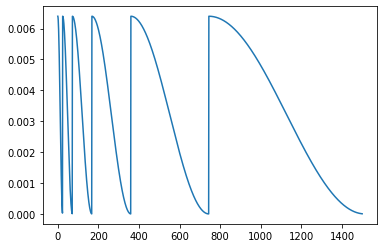

In [ ]:
#@title CosineDecayRestarts {display-mode: "form", run: "auto"}

STEPS = math.ceil(count_data_items(train_filenames) / BATCH_SIZE) * EPOCHS
LR_START = 1e-3 #@param {type: "number"}
LR_START *= strategy.num_replicas_in_sync
LR_MIN = 1e-5 #@param {type: "number"}
N_RESTARTS =  5#@param {type: "number"}
T_MUL = 2.0 #@param {type: "number"}
M_MUL =  1#@param {type: "number"}
STEPS_START = math.ceil((T_MUL-1)/(T_MUL**(N_RESTARTS+1)-1) * STEPS)

schedule = tf.keras.experimental.CosineDecayRestarts(
    first_decay_steps=STEPS_START,
    initial_learning_rate=LR_START,
    alpha=LR_MIN,
    m_mul=M_MUL,
    t_mul=T_MUL)

x = [i for i in range(STEPS)]
y = [schedule(s) for s in range(STEPS)]
plt.plot(x, y)

print('{:d} total epochs and {:d} steps per epoch'
        .format(EPOCHS, STEPS // EPOCHS))
print(schedule.get_config())



# Callbacks

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='001_best_model.h5',
        monitor='val_loss',
        save_best_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=5,
        restore_best_weights=True,
        verbose=1)
    ]
    
model.compile(
    optimizer=tf.keras.optimizers.Adam(schedule),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
pred (Dense)                 (None, 104)               159848    
Total params: 10,943,383
Trainable params: 10,856,080
Non-trainable params: 87,303
_________________________________________________________________


# Training

## Tune the `normalization` layer

In [ ]:
def generate_unlabeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    image = image / 255.0
    return image

In [ ]:
adapt_ds = tf.data.TFRecordDataset(train_filenames, num_parallel_reads=AUTOTUNE)
adapt_ds = (adapt_ds
            .map(generate_unlabeled_tfrecord, num_parallel_calls=AUTOTUNE)
            .shuffle(2048)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))

In [ ]:
%%time
model.get_layer('efficientnetb3').get_layer('normalization_1').adapt(adapt_ds)

In [ ]:
model.save_weights("000_normalization.h5")

In [ ]:
model.load_weights("000_normalization.h5")

## Train the whole

In [ ]:
#collapse-output
history = model.fit(
    x=train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    steps_per_epoch=STEPS//BATCH_SIZE,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/30
5/5 - 9s - loss: 4.6731 - sparse_categorical_accuracy: 0.0164 - val_loss: 4.4839 - val_sparse_categorical_accuracy: 0.0428
Epoch 2/30
5/5 - 5s - loss: 4.2220 - sparse_categorical_accuracy: 0.1227 - val_loss: 3.9313 - val_sparse_categorical_accuracy: 0.1541
Epoch 3/30
5/5 - 5s - loss: 3.6802 - sparse_categorical_accuracy: 0.2195 - val_loss: 4.1627 - val_sparse_categorical_accuracy: 0.1711
Epoch 4/30
5/5 - 5s - loss: 3.1707 - sparse_categorical_accuracy: 0.3148 - val_loss: 3.2700 - val_sparse_categorical_accuracy: 0.2980
Epoch 5/30
5/5 - 4s - loss: 2.8780 - sparse_categorical_accuracy: 0.3516 - val_loss: 3.0248 - val_sparse_categorical_accuracy: 0.3279
Epoch 6/30
5/5 - 5s - loss: 2.3836 - sparse_categorical_accuracy: 0.4508 - val_loss: 3.0758 - val_sparse_categorical_accuracy: 0.3373
Epoch 7/30
5/5 - 5s - loss: 2.1572 - sparse_categorical_accuracy: 0.4813 - val_loss: 2.4670 - val_sparse_categorical_accuracy: 0.4370
Epoch 8/30
5/5 - 5s - loss: 1.9592 - sparse_categorical_accura

In [ ]:
def plot_hist(hist):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss over epochs')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='best')
    plt.show()

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

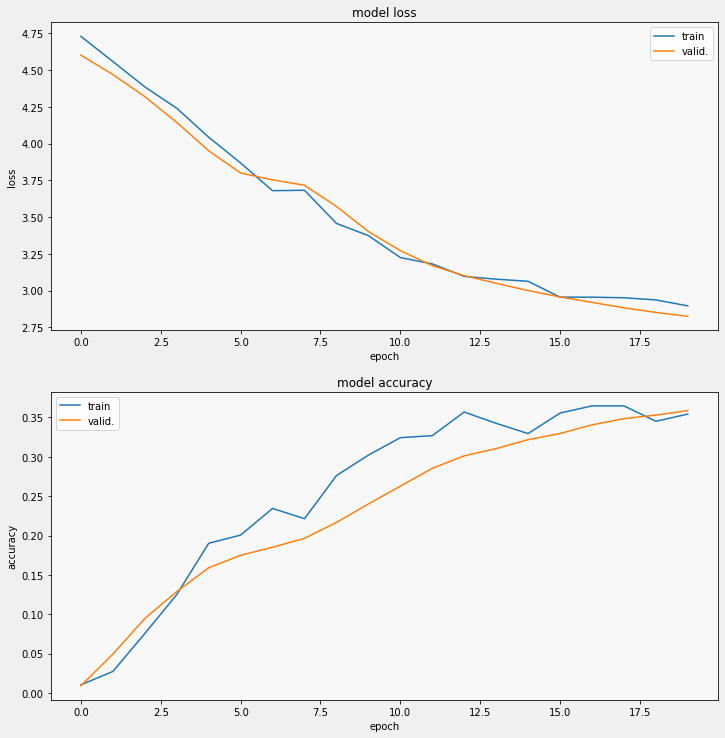

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
cmat_ds = tf.data.TFRecordDataset(valid_filenames, num_parallel_reads=AUTOTUNE)
cmat_ds = (cmat_ds
            .map(collate_labeled_tfrecord)
            .batch(BATCH_SIZE)
            .cache()
            .prefetch(AUTOTUNE))

images_ds = cmat_ds.map(lambda image, label: image)
labels_ds = cmat_ds.map(lambda image, label: label).unbatch()

In [ ]:
cm_correct_labels = next(iter(labels_ds.batch(count_data_items(valid_filenames)))).numpy()
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

You might be familiar with metrics like [F1-score](https://en.wikipedia.org/wiki/F1_score) or [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). This cell will compute these metrics and display them with a plot of the confusion matrix. (These metrics are defined in the Scikit-learn module `sklearn.metrics`; we've imported them in the helper script for you.)

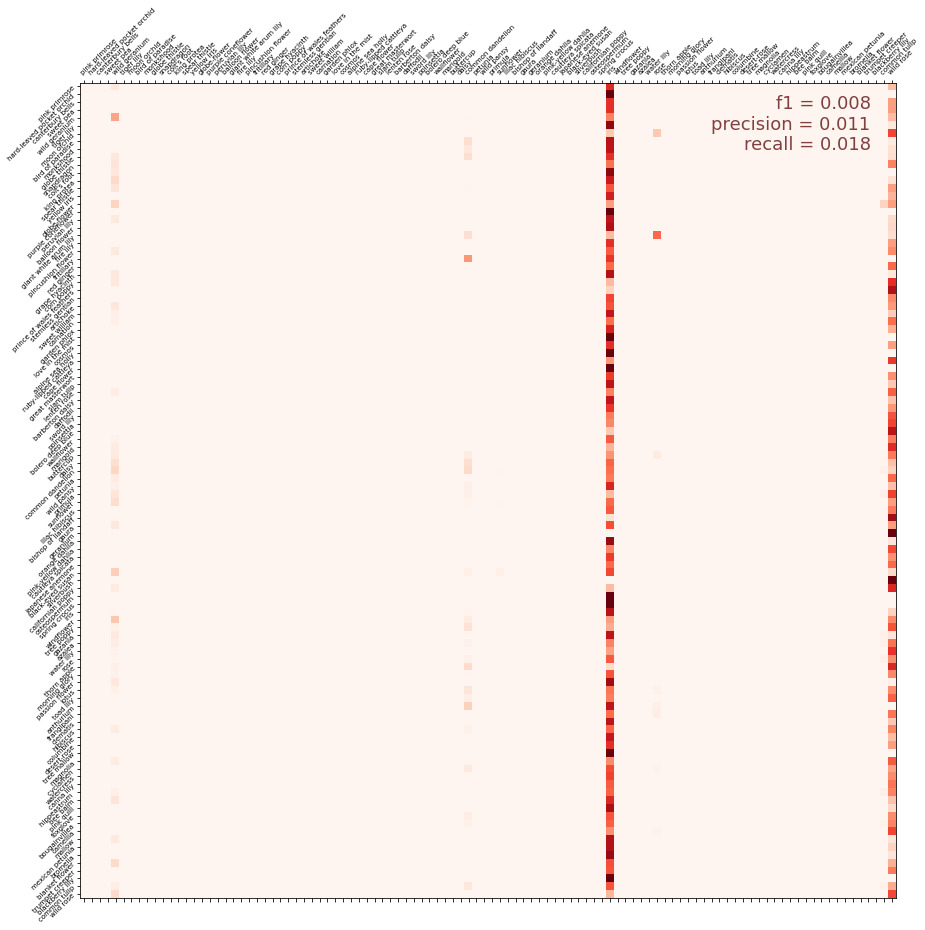

In [ ]:
score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)

# Visual Validation

It can also be helpful to look at some examples from the validation set and see what class your model predicted. This can help reveal patterns in the kinds of images your model has trouble with.
This cell will set up the validation set to display 20 images at a time -- you can change this to display more or fewer, if you like.

# 1% Better Everyday

**reference**
- [Create Your First Submission
](https://www.kaggle.com/ryanholbrook/create-your-first-submission)
- [How to use my own data source?
](https://www.kaggle.com/c/flower-classification-with-tpus/discussion/130326)
- [TPU-speed data pipelines: tf.data.Dataset and TFRecords
](https://codelabs.developers.google.com/codelabs/keras-flowers-data/#5)
---
**todos**
- Comment out the 1/255.0 in the image preprocessing
- Reorganize the notebook structure
---
**done**
